# **Section 1: Introduction**

## **1a: Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ngboost import NGBRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer

## **1b: Model Performance Metric: sMAPE**

To assess and compare predictive performance across models, we adopted symmetric mean absolute percentage error (sMAPE) as our primary accuracy metric. sMAPE is a modified version of MAPE that calculates the absolute error between actual and predicted values, divided by the average of those two values. This adjustment makes the metric scale-independent and prevents it from being overly sensitive to small actual values. It also ensures that overpredictions and underpredictions are penalized equally. 

Please refer to the transition document for a detailed explanation of the sMAPE metric and its advantages over other metrics like RMSE and MAE.

In [2]:
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = ((np.abs(y_true) + np.abs(y_pred)))
    return np.mean(numerator / denominator) * 100

## **1c: Data**

In [3]:
df = pd.read_csv("clean_FinalPAHODATA.csv")
df.sample(5)

,Country,PurchaseOrderDate,Type,Product,Variant,SupplierCountry,Quantity,Value,Freight,Air,BDI,Doses,Distance,Volume,StorageCondition,Openness,Weight,TotalWeight
3947,Guatemala,2024-08-16,Vaccine,7120,10,India,11890,2247.21,1200.0,169.6,1814,10,15042.300,NaN,NaN,3.3,0.027971,33.257459
3890,Grenada,2024-08-12,Vaccine,6001,97,Belgium,3000,19500.00,2520.0,169.6,1814,1,7305.682,50.56,"Between +2° C and + 8° C, must not be frozen",2.7,0.009767,29.300001
1856,Bermuda,2023-04-24,Vaccine,1301,95,France,200,1100.00,930.0,184.1,1576,1,5764.324,NaN,NaN,2.0,0.009767,1.953333
1208,Haiti,2022-08-25,Vaccine,6001,81,Belgium,197050,492625.00,21799.0,217.1,965,1,7499.688,NaN,NaN,2.8,0.009767,1924.521732
3273,Colombia,2024-04-26,Vaccine,1701,5,India,3215,16075.00,600.0,166.7,1685,5,15290.560,NaN,NaN,1.8,0.034568,22.227172


### **Data Dictionary**

| Column Name            | Data Type        | Description |
|------------------------|------------------|-------------|
| `Freight`              | `float64`        | (**Response**) **Cost** of freight charges for the shipment. |
| `Country`              | `object`         | The **destination** country receiving the shipment. |
| `PurchaseOrderDate`    | `datetime64[ns]` | The **date** the purchase order was placed, in MM/DD/YYYY format. |
| `Type`                 | `object`         | Product **category**, such as vaccine, syringe, or immunoglobulin. |
| `Product`              | `object`          | 4-digit product code. The first two digits indicate the product type, and the last two indicate the version. |
| `Variant`              | `object`          | 2-digit code indicating dose count or presentation (e.g., vial or prefilled syringe). |
| `SupplierCountry`      | `object`         | The **origin** country from which the product was supplied. |
| `Quantity`             | `int64`          | Number of **units** included in the shipment. |
| `Value`                | `float64`        | Total **monetary value** of the shipment. |
| `Air`                  | `float64`        | AIR **freight index** value at the time of shipment. |
| `BDI`                  | `int64`          | **Baltic Dry Index** (BDI) at the time of shipment. |
| `Doses`                | `int64`          | Number of **doses** per vial. |
| `Distance`             | `float64`        | **Approximate distance** the shipment traveled. Calculated by the distance between the capital cities of the supplier and receiving country |
| `Volume`               | `float64`        | Total shipment volume in cubic centimeters (**cm³**). |
| `StorageCondition`     | `object`         | Indicates storage condition **temperature**-wise. |
| `Openness`             | `float64`        | A score indicating the "**openness**" of the receiving country. |
| `Weight`               | `float64`        | Weight per unit (vial, syringe, etc.), provided by Javier, in **kilograms**. |
| `TotalShipmentWeight`  | `float64`        | Total weight of the entire shipment, calculated as `Weight * Quantity / Doses`, in **kilograms**. |


In [4]:
print("Data Types:\n", df.dtypes)
print("\n\nData Shape:\n", df.shape)
print("\n\nData Columns:\n", df.columns)

Data Types:
 Country               object
PurchaseOrderDate     object
Type                  object
Product                int64
Variant                int64
SupplierCountry       object
Quantity               int64
Value                float64
Freight              float64
Air                  float64
BDI                    int64
Doses                  int64
Distance             float64
Volume               float64
StorageCondition      object
Openness             float64
Weight               float64
TotalWeight          float64
dtype: object


Data Shape:
 (4219, 18)


Data Columns:
 Index(['Country', 'PurchaseOrderDate', 'Type', 'Product', 'Variant',
       'SupplierCountry', 'Quantity', 'Value', 'Freight', 'Air', 'BDI',
       'Doses', 'Distance', 'Volume', 'StorageCondition', 'Openness', 'Weight',
       'TotalWeight'],
      dtype='object')


In [5]:
# saving a clean copy of the original unprocessed dataframe if needed later
df_backup = df.copy()

# **Section 2: Data Preprocessing**

## **2a: Missing Values**

In [6]:
# missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Country                 0
PurchaseOrderDate       0
Type                    0
Product                 0
Variant                 0
SupplierCountry         0
Quantity                0
Value                   0
Freight                 0
Air                     0
BDI                     0
Doses                   0
Distance                0
Volume               3046
StorageCondition     3046
Openness                0
Weight                  0
TotalWeight             0
dtype: int64


There are 2 variables/columns in the dataset are both frequently missing for the majority of the dataset. We decided to drop these rows from the dataset. Just as we predicted the `Weight` column, we can likely impute the missing values for `Volume` and `StorageCondition` through research and the usage of other columns. However, we decided to drop these rows for now

The columns with missing values included:
- `Volume`
- `StorageCondition`

We found that training our models without these rows significantly improved the performance of our models.

In [7]:
# save a copy of the dataframe with only the rows that arent missing volume and storage condition (only 1173 rows out of the 4219 total)
df_volumes = df[df['StorageCondition'].isnull() == False]
df_volumes.shape

(1173, 18)

You may comment out the code below if you want to see the missing values in the dataset.

In [8]:
# uncomment this if you want to run the models on the full vs non missing volume data
# df = df_volumes.copy()

# uncomment this if you want to run the models on the full vs non missing volume data
# df.drop(columns=['StorageCondition','Volume'], inplace=True)

In [9]:
# df

### Predicting Missing Values
We can predict the missing values in the `Volume` and `StorageCondition` columns using the other columns in the dataset. We can use a regression model to predict the missing values based on the other columns. This is a common approach in data preprocessing when dealing with missing values.

In [10]:
# Split
df_train_sc = df[df['StorageCondition'].notnull()].copy()
df_predict_sc = df[df['StorageCondition'].isnull()].copy()
le = LabelEncoder()
df_train_sc['SC_encoded'] = le.fit_transform(df_train_sc['StorageCondition'])

In [11]:
# Drop columns not available in both sets
cols_to_drop = ['StorageCondition', 'SC_encoded', 'Volume', 'Freight', 'LogFreight']
available_features = [col for col in df.columns if col not in cols_to_drop]

combined = pd.concat([df_train_sc, df_predict_sc])
combined_encoded = pd.get_dummies(combined[available_features], drop_first=True)

# Re-split encoded features
X_sc = combined_encoded.iloc[:len(df_train_sc)]
X_predict_sc = combined_encoded.iloc[len(df_train_sc):]
y_sc = df_train_sc['SC_encoded']

In [12]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_sc, y_sc)

predicted_labels = clf.predict(X_predict_sc)
df_predict_sc['SC_encoded'] = predicted_labels
df_predict_sc['StorageCondition'] = le.inverse_transform(predicted_labels)

In [13]:
df_combined = pd.concat([df_train_sc, df_predict_sc], ignore_index=True)

df_train_vol = df_combined[df_combined['Volume'].notnull()].copy()
df_predict_vol = df_combined[df_combined['Volume'].isnull()].copy()
excluded_cols = ['Volume', 'Freight', 'LogFreight']
features_vol = [col for col in df_combined.columns if col not in excluded_cols]

combined_encoded = pd.get_dummies(df_combined[features_vol], drop_first=True)

X_vol = combined_encoded.iloc[:len(df_train_vol)]
y_vol = df_train_vol['Volume']
X_predict_vol = combined_encoded.iloc[len(df_train_vol):]

In [14]:
reg = RandomForestRegressor(random_state=42)
reg.fit(X_vol, y_vol)

df_predict_vol['Volume'] = reg.predict(X_predict_vol)

In [15]:
df_full_imputed = pd.concat([df_train_vol, df_predict_vol], ignore_index=True)
df_full_imputed = df_full_imputed.drop(columns=['SC_encoded'])  # cleanup

In [16]:
df = df_full_imputed.copy()

## **2b: Preprocessing**

### Recreated previously attempted ratios

In [17]:
# Interactive features
# creating new features based on the existing features to help the model learn better
df['PurchaseOrderDate'] = pd.to_datetime(df['PurchaseOrderDate'])

df['QtyTimesDist'] = df['Quantity'] * df['Distance']
df['QtyPerDist'] = df['Quantity'] / df['Distance']
df['VialsPerDist'] = df['QtyPerDist'] * df['Doses']

df['VialsPerDist_AirAdj'] = df['VialsPerDist'] * df['Air']
df['VialsPerDist_BDIAdj'] = df['VialsPerDist'] * df['BDI']

df['TotalWeightTimesDist'] = df['TotalWeight'] * df['Distance']
df['TotalWeightTimesDist_AirAdj'] = df['TotalWeightTimesDist'] * df['Air']

In [18]:
print(df.shape)
print(df.columns)

(4219, 25)
Index(['Country', 'PurchaseOrderDate', 'Type', 'Product', 'Variant',
       'SupplierCountry', 'Quantity', 'Value', 'Freight', 'Air', 'BDI',
       'Doses', 'Distance', 'Volume', 'StorageCondition', 'Openness', 'Weight',
       'TotalWeight', 'QtyTimesDist', 'QtyPerDist', 'VialsPerDist',
       'VialsPerDist_AirAdj', 'VialsPerDist_BDIAdj', 'TotalWeightTimesDist',
       'TotalWeightTimesDist_AirAdj'],
      dtype='object')


### Encode categorical variables so the model can train on them
Encoding is when you created "dummy" variables for each categorical variable column. Thus, each unique value in each categorical column gets its own column. The value in that column is 1 if the particular row has that value and 0 if it does not. This allows the model to understand categorical variables as numbers.

In [19]:
# encoding categorical variables so they can eventually be used in the model
# encoding is done by creating dummy variables for each category
# so each unique value in the column becomes a new column
# and the value in that column is 1 if the original value was that category, and 0 otherwise
df = pd.get_dummies(df, columns=['SupplierCountry', 'Country'], drop_first=True)
df = pd.get_dummies(df, columns=['Product', 'Variant','Type'], drop_first=True)

if 'StorageCondition' in df.columns:
    df = pd.get_dummies(df, columns=['StorageCondition'], drop_first=True)

In [20]:
print(df.shape)
print(df.columns)

(4219, 166)
Index(['PurchaseOrderDate', 'Quantity', 'Value', 'Freight', 'Air', 'BDI',
       'Doses', 'Distance', 'Volume', 'Openness',
       ...
       'Variant_10', 'Variant_12', 'Variant_14', 'Variant_81', 'Variant_95',
       'Variant_97', 'Type_Syringe', 'Type_Vaccine',
       'StorageCondition_Between +2° C and + 8° C, must not be frozen',
       'StorageCondition_Should be -20° C or below'],
      dtype='object', length=166)


### Separating the order date variable into more variables, each for the time of year, month, and day, etc

In [21]:
# splitting the order date into separate columns for year, month, day, day of week, and whether it is a weekend
# this is done so that the model can learn the seasonality of the data
# df['Year'] = df['PurchaseOrderDate'].dt.year
df['Month'] = df['PurchaseOrderDate'].dt.month
df['Day'] = df['PurchaseOrderDate'].dt.day


df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)


df['DayOfWeek'] = df['PurchaseOrderDate'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# drop dayofweek
# df.drop(columns=['DayOfWeek'], inplace=True)
df.drop(columns=['Day','Month'], inplace=True)

In [22]:
print(df.shape)
print(df.columns)

(4219, 172)
Index(['PurchaseOrderDate', 'Quantity', 'Value', 'Freight', 'Air', 'BDI',
       'Doses', 'Distance', 'Volume', 'Openness',
       ...
       'Type_Syringe', 'Type_Vaccine',
       'StorageCondition_Between +2° C and + 8° C, must not be frozen',
       'StorageCondition_Should be -20° C or below', 'Month_sin', 'Month_cos',
       'Day_sin', 'Day_cos', 'DayOfWeek', 'IsWeekend'],
      dtype='object', length=172)


### We log transform the target variable to reduce the skewness of the data
This is a common practice in regression to make the distribution of the target variable more normal. The log transformation can help improve the performance of the model

In [23]:
# we are going to use the log of the freight as the target variable
# logging the target variable helps adjust for the skewness of the data
df['LogFreight'] = np.log1p(df['Freight'])
target = 'LogFreight'

In [24]:
print(df.shape)
print(df.columns)

(4219, 173)
Index(['PurchaseOrderDate', 'Quantity', 'Value', 'Freight', 'Air', 'BDI',
       'Doses', 'Distance', 'Volume', 'Openness',
       ...
       'Type_Vaccine',
       'StorageCondition_Between +2° C and + 8° C, must not be frozen',
       'StorageCondition_Should be -20° C or below', 'Month_sin', 'Month_cos',
       'Day_sin', 'Day_cos', 'DayOfWeek', 'IsWeekend', 'LogFreight'],
      dtype='object', length=173)


In [25]:
df.sample(5)

,PurchaseOrderDate,Quantity,Value,Freight,Air,BDI,Doses,Distance,Volume,Openness,...,Type_Vaccine,"StorageCondition_Between +2° C and + 8° C, must not be frozen",StorageCondition_Should be -20° C or below,Month_sin,Month_cos,Day_sin,Day_cos,DayOfWeek,IsWeekend,LogFreight
2472,2023-04-11,2650,1319.21,3406.110000,184.1,1576,1,8391.007,137.680826,1.3,...,False,True,False,8.660254e-01,-0.500000,0.790776,-0.612106,1,0,8.133620
3659,2024-05-21,386000,9225.40,35661.560000,165.5,1815,1,15042.300,90.851132,3.3,...,False,True,False,5.000000e-01,-0.866025,-0.897805,-0.440394,1,0,10.481857
309,2022-07-27,1000,110.00,2097.018181,217.3,1895,10,3084.049,98.400000,3.3,...,True,True,False,-5.000000e-01,-0.866025,-0.724793,0.688967,2,0,7.648748
2175,2022-12-14,10327,511186.50,26850.200000,203.5,1515,1,10629.060,140.747667,1.4,...,False,True,False,-2.449294e-16,1.000000,0.299363,-0.954139,2,0,10.198066
3863,2024-07-04,200,250.00,2593.000000,169.6,1708,5,14092.050,97.365618,3.3,...,True,True,False,-5.000000e-01,-0.866025,0.724793,0.688967,3,0,7.860956


# **Section 3: Model Training**

In [26]:
features = [c for c in df.columns if c not in {"Freight", "LogFreight"}]

In [27]:
features

['PurchaseOrderDate',
 'Quantity',
 'Value',
 'Air',
 'BDI',
 'Doses',
 'Distance',
 'Volume',
 'Openness',
 'Weight',
 'TotalWeight',
 'QtyTimesDist',
 'QtyPerDist',
 'VialsPerDist',
 'VialsPerDist_AirAdj',
 'VialsPerDist_BDIAdj',
 'TotalWeightTimesDist',
 'TotalWeightTimesDist_AirAdj',
 'SupplierCountry_Belgium',
 'SupplierCountry_Brazil',
 'SupplierCountry_Bulgaria',
 'SupplierCountry_China',
 'SupplierCountry_Denmark',
 'SupplierCountry_Finland',
 'SupplierCountry_France',
 'SupplierCountry_Germany',
 'SupplierCountry_India',
 'SupplierCountry_Indonesia',
 'SupplierCountry_Israel',
 'SupplierCountry_Italy',
 'SupplierCountry_Korea, Republic of',
 'SupplierCountry_Netherlands',
 'SupplierCountry_Panama',
 'SupplierCountry_Qatar',
 'SupplierCountry_Sweden',
 'SupplierCountry_Switzerland',
 'SupplierCountry_United Arab Emirates',
 'SupplierCountry_United Kingdom',
 'SupplierCountry_United States of America',
 'Country_Antigua and Barbuda ',
 'Country_Argentina',
 'Country_Aruba',
 'Co

In [28]:
print("Total features in model: ", len(features))

Total features in model:  171


In [29]:
# gather all preprocessed data into a single dataframe to be used for the model
df_model = df[features + [target]].dropna()
df_model.shape

(4219, 172)

In [30]:
df_model = df_model.sort_values('PurchaseOrderDate')  # making sure df is sorted by time

cutoff = int(len(df_model) * 0.8) # 80% of the data for training, 20% for testing
X_train = df_model[features].iloc[:cutoff]
y_train = df_model[target].iloc[:cutoff]
X_test = df_model[features].iloc[cutoff:]
y_test = df_model[target].iloc[cutoff:]

# no longer need purchaseorderdata column
X_train = X_train.drop(columns=['PurchaseOrderDate'])
X_test = X_test.drop(columns=['PurchaseOrderDate'])
features = [c for c in features if c != 'PurchaseOrderDate']

In [31]:
X_train.columns = X_train.columns.str.replace(r'[\"\'\\/:;<>\[\]\{\},\s]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[\"\'\\/:;<>\[\]\{\},\s]', '_', regex=True)

In [32]:
y_train.shape, y_test.shape

((3375,), (844,))

## **2a: NGBoost**

In [33]:
param_grid = {
    'Base': [
        DecisionTreeRegressor(criterion='friedman_mse', max_depth=3),
        DecisionTreeRegressor(criterion='friedman_mse', max_depth=4),
        DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)
        ],
    'learning_rate': [0.03, 0.05, 0.1],
    'n_estimators': [100, 150],
    'col_sample': [0.5, 0.7],
    'minibatch_frac': [1.0]
}

model = GridSearchCV(
    estimator=NGBRegressor(verbose=False, random_state=42),
    param_grid=param_grid,
    cv=TimeSeriesSplit(n_splits=10),
    scoring=make_scorer(smape, greater_is_better=False),
    n_jobs=-1
)

In [34]:
_ = model.fit(X_train, y_train)
best_model = model.best_estimator_

In [35]:
print("Train sMAPE:", smape(np.expm1(y_train), np.expm1(model.predict(X_train))))

Train sMAPE: 9.470985337858247


In [36]:
y_test = np.expm1(y_test)

In [37]:
# calculate smape for actual vs predicted (log adjusted)
y_pred_ngboost = np.expm1(model.predict(X_test))
print("sMAPE:", smape(y_test, y_pred_ngboost))

sMAPE: 17.939426548613653


In [38]:
# save model and predictions for later (also printing smapes the ensure i saved them correctly)
NGBoost_model = model
NGBoost_predictions = np.expm1(model.predict(X_test))
print("sMAPE:", smape(y_test, NGBoost_predictions))

sMAPE: 17.939426548613653


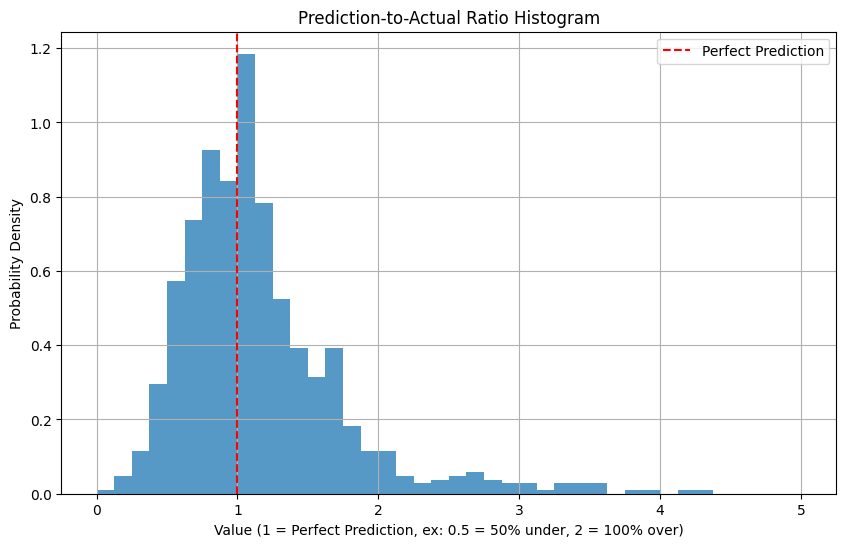

In [39]:
plt.figure(figsize=(10, 6))
plt.hist(y_pred_ngboost / y_test, bins=40, range=(0, 5), density=True, alpha=0.75)
plt.axvline(1, color='red', linestyle='--', label='Perfect Prediction')
plt.title("Prediction-to-Actual Ratio Histogram")
plt.xlabel("Value (1 = Perfect Prediction, ex: 0.5 = 50% under, 2 = 100% over)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()

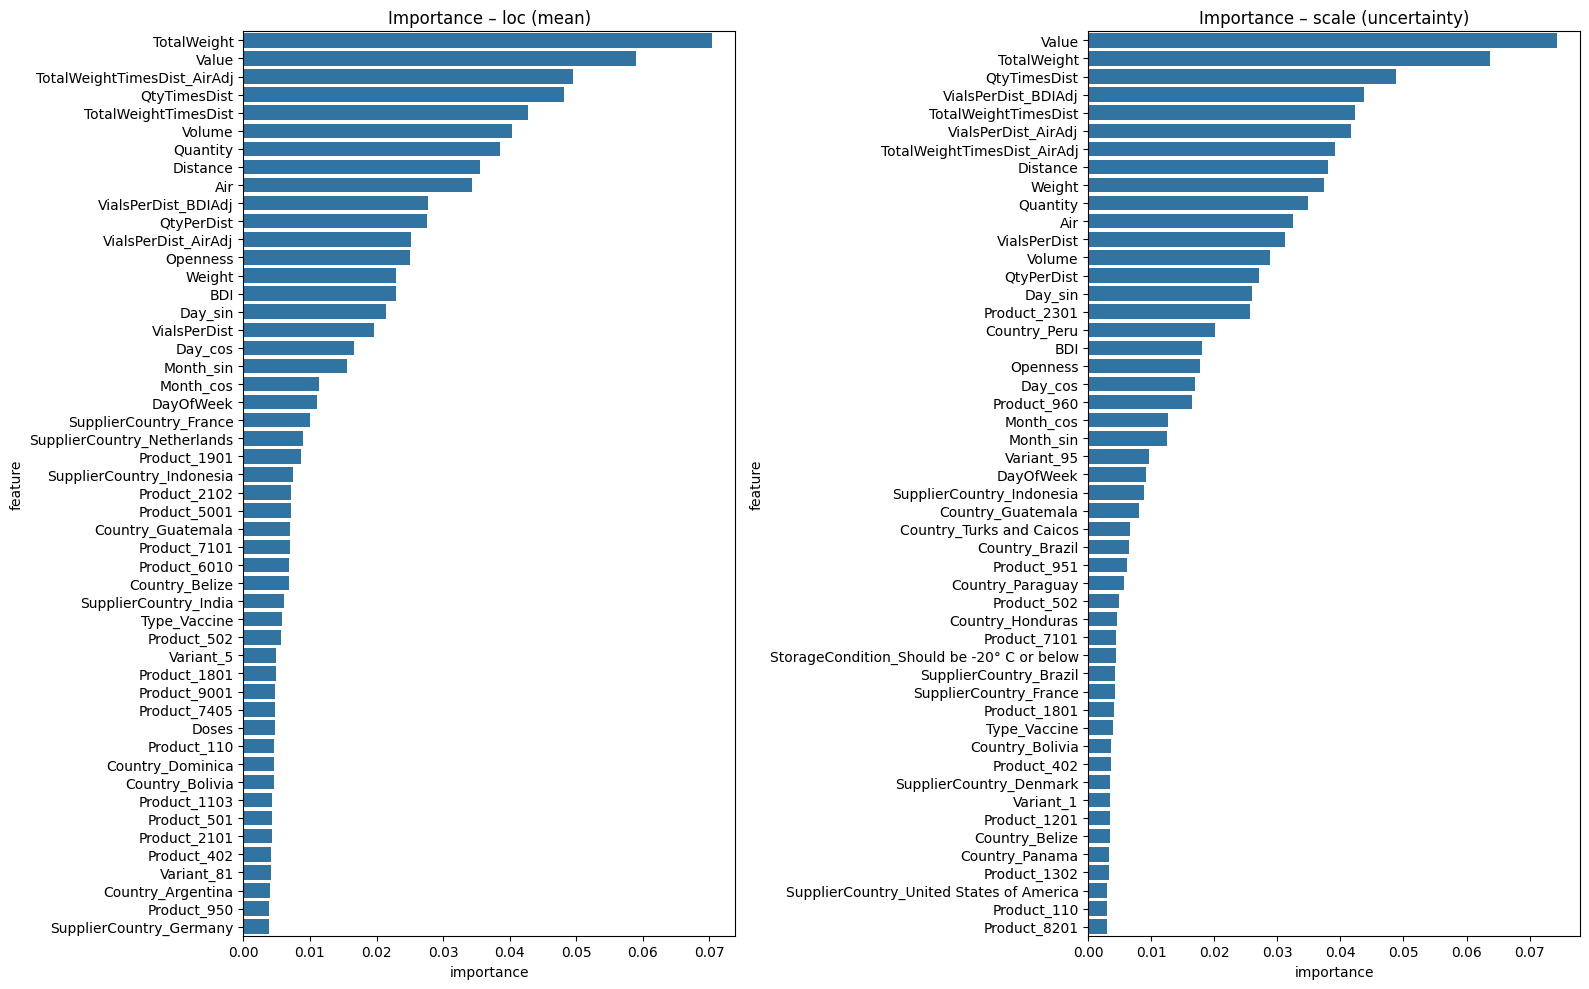

In [40]:
# Feature importance (top‑20 for loc & scale)
loc_imp, scale_imp = best_model.feature_importances_
df_loc = (pd.DataFrame({"feature": features, "importance": loc_imp}).sort_values("importance", ascending=False).head(50))
df_scale = (pd.DataFrame({"feature": features, "importance": scale_imp}).sort_values("importance", ascending=False).head(50))

fig, axes = plt.subplots(1, 2, figsize=(16, 10))
sns.barplot(data=df_loc, y="feature", x="importance", ax=axes[0])
axes[0].set_title("Importance – loc (mean)")
sns.barplot(data=df_scale, y="feature", x="importance", ax=axes[1])
axes[1].set_title("Importance – scale (uncertainty)")
plt.tight_layout()
plt.show()

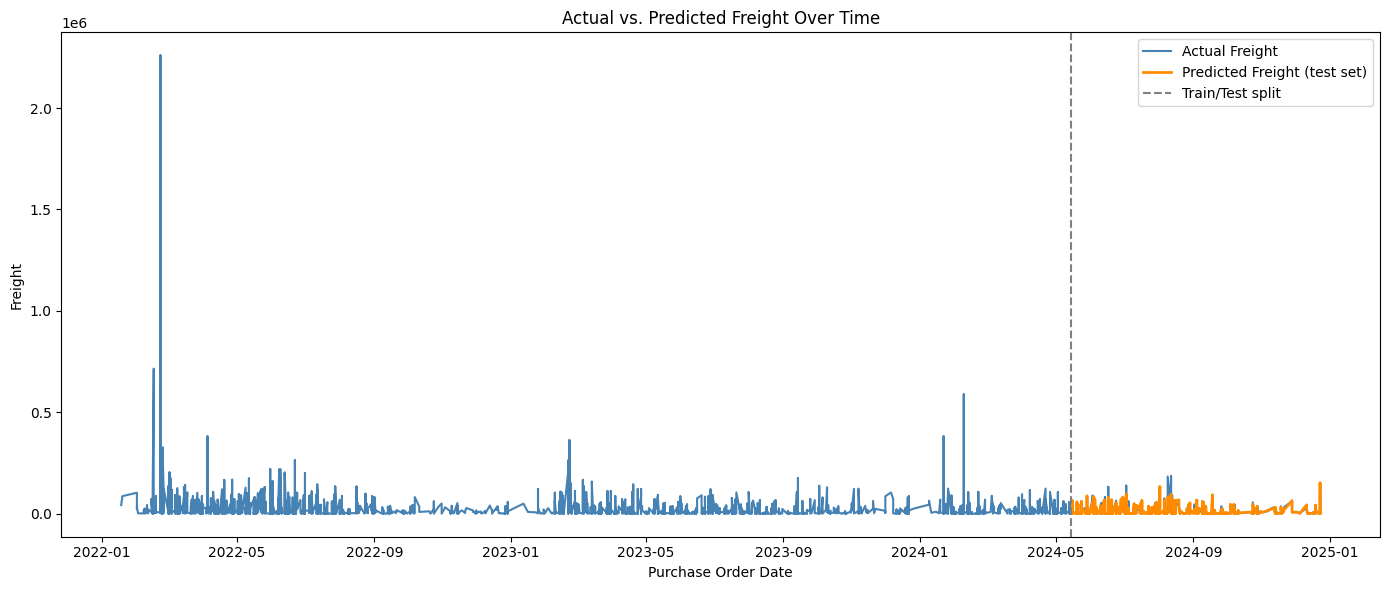

In [41]:
plt.figure(figsize=(14, 6))
plt.plot(df_model['PurchaseOrderDate'],np.expm1(df_model['LogFreight']),label='Actual Freight', color='steelblue')
plt.plot(df_model['PurchaseOrderDate'].iloc[cutoff:],y_pred_ngboost,label='Predicted Freight (test set)',color='darkorange', linewidth=2)
plt.axvline(df_model['PurchaseOrderDate'].iloc[cutoff:].iloc[0], color='grey', linestyle='--', label='Train/Test split')
plt.title('Actual vs. Predicted Freight Over Time')
plt.xlabel('Purchase Order Date')
plt.ylabel('Freight')
plt.legend()
plt.tight_layout()
plt.show()

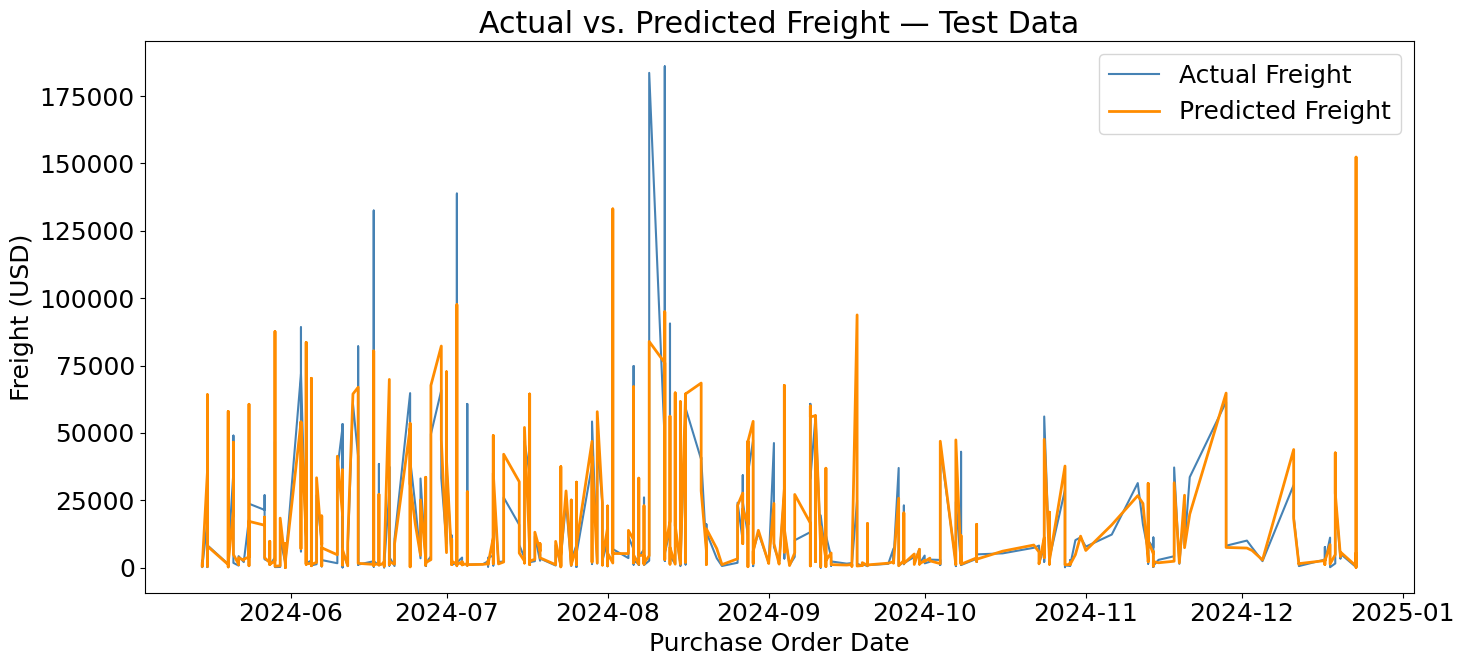

In [42]:
plt.figure(figsize=(15, 7))
plt.rcParams.update({'font.size': 18})
plt.plot(df_model['PurchaseOrderDate'].iloc[cutoff:], y_test, label='Actual Freight', color='steelblue')
plt.plot(df_model['PurchaseOrderDate'].iloc[cutoff:], y_pred_ngboost, label='Predicted Freight', color='darkorange', linewidth=2)
plt.title('Actual vs. Predicted Freight — Test Data')
plt.xlabel('Purchase Order Date')
plt.ylabel('Freight (USD)')
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8]
}


nmodel = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    cv=TimeSeriesSplit(n_splits=10),
    scoring=make_scorer(smape, greater_is_better=False),
    n_jobs=-1,
    verbose=1
)

_ = nmodel.fit(X_train, y_train)
best_model = model.best_estimator_

Fitting 10 folds for each of 48 candidates, totalling 480 fits


In [44]:
# best model hyper params
print(nmodel.best_params_)
print("Train sMAPE:", smape(np.expm1(y_train), np.expm1(nmodel.predict(X_train))))
# calculate smape for actual vs predicted (log adjusted)
y_pred = np.expm1(nmodel.predict(X_test))
print("XGBoost sMAPE:", smape(y_test, y_pred))

{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 1.0}
Train sMAPE: 10.63168695039534
XGBoost sMAPE: 18.122180538765683


In [45]:
# save model and predictions for later (also printing smapes the esnure i saved them correctly)
XGBoost_model = nmodel
XGBoost_predictions = np.expm1(XGBoost_model.predict(X_test))
print("XGBoost sMAPE:", smape(y_test, np.expm1(XGBoost_model.predict(X_test))))
print("XGBoost sMAPE:", smape(y_test, XGBoost_predictions))

XGBoost sMAPE: 18.122180538765683
XGBoost sMAPE: 18.122180538765683


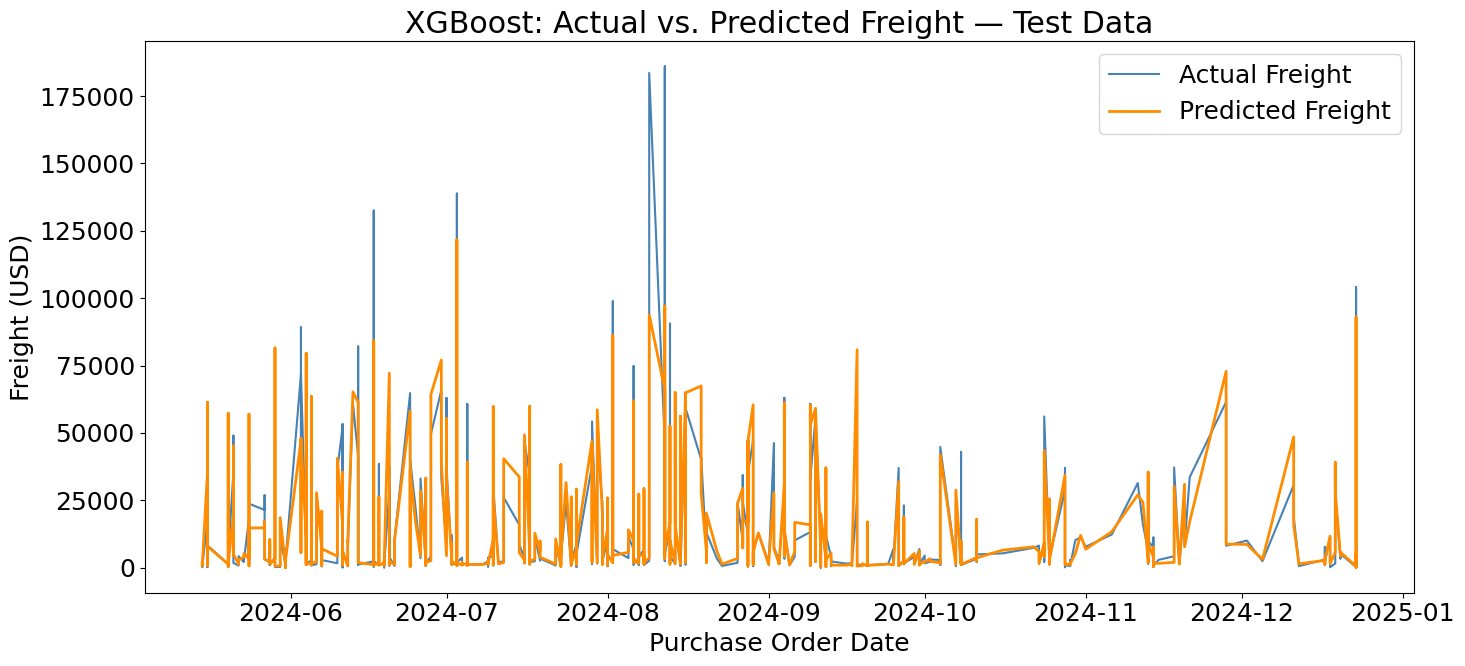

In [46]:
plt.figure(figsize=(15, 7))
plt.rcParams.update({'font.size': 18})
plt.plot(df_model['PurchaseOrderDate'].iloc[cutoff:], y_test, label='Actual Freight', color='steelblue')
plt.plot(df_model['PurchaseOrderDate'].iloc[cutoff:], XGBoost_predictions, label='Predicted Freight', color='darkorange', linewidth=2)
plt.title('XGBoost: Actual vs. Predicted Freight — Test Data')
plt.xlabel('Purchase Order Date')
plt.ylabel('Freight (USD)')
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
param_grid = {
    'criterion': ['friedman_mse'], # add parameters to search over
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 150]
}

# Instantiate the RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=5)) # 5-fold cross-validation

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(grid_search.best_params_)
y_pred = best_model.predict(X_test)

_ = rf.fit(X_train, y_train)

{'criterion': 'friedman_mse', 'max_depth': 5, 'n_estimators': 100}


In [48]:
y_pred = np.expm1(rf.predict(X_test))
print("Random Forest sMAPE:", smape(y_test, y_pred))

Random Forest sMAPE: 18.701861473500017


In [49]:
# save model and predictions for later (also printing smapes the esnure i saved them correctly)
RF_predictions = y_pred
RF_model = rf
print("RF sMAPE:", smape(y_test, np.expm1(RF_model.predict(X_test))))
print("RF sMAPE:", smape(y_test, RF_predictions))

RF sMAPE: 18.701861473500017
RF sMAPE: 18.701861473500017


In [50]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_svr = scaler.fit_transform(X_train)
X_test_svr = scaler.transform(X_test)

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_svr, y_train)

SVR_predictions = np.expm1(svr_model.predict(X_test_svr))
print("SVR Regression sMAPE:", smape(y_test, SVR_predictions))

SVR Regression sMAPE: 25.01169176286295


In [51]:
print("SVR sMAPE:", smape(y_test, np.expm1(svr_model.predict(X_test_svr))))
print("SVR sMAPE:", smape(y_test, SVR_predictions))

SVR sMAPE: 25.01169176286295
SVR sMAPE: 25.01169176286295


In [52]:

all_predictions = np.vstack([NGBoost_predictions, XGBoost_predictions, RF_predictions, SVR_predictions])

ensemble_predictions = np.median(all_predictions, axis=0)
print("Median Ensemble sMAPE:", smape(y_test, ensemble_predictions))

Median Ensemble sMAPE: 17.681648116707667


In [53]:
NGBoost_train_pred = np.expm1(NGBoost_model.predict(X_train))
XGBoost_train_pred = np.expm1(XGBoost_model.predict(X_train))
RF_train_pred = np.expm1(RF_model.predict(X_train))
SVR_train_pred = np.expm1(svr_model.predict(X_train_svr))

stacked_X_train = np.vstack([NGBoost_train_pred, XGBoost_train_pred, RF_train_pred, SVR_train_pred]).T
from sklearn.linear_model import RidgeCV

meta_model = RidgeCV(alphas=np.logspace(-3, 3, 10))
meta_model.fit(stacked_X_train, y_train)

stacked_X_test = np.vstack([NGBoost_predictions,XGBoost_predictions,RF_predictions,SVR_predictions]).T

In [54]:
stacked_predictions = np.expm1(meta_model.predict(stacked_X_test))
print("Stacking Ensemble sMAPE:", smape(y_test, stacked_predictions))

Stacking Ensemble sMAPE: 41.47314888059272


In [55]:
Stacking_predictions = stacked_predictions
Stacking_model = meta_model

In [56]:
# simple average ensemble
simple_avg_predictions = np.mean(all_predictions, axis=0)
print("Simple Average Ensemble sMAPE:", smape(y_test, simple_avg_predictions))

Simple Average Ensemble sMAPE: 18.480879378033535


In [57]:
# full report on all smapes
print("NGBoost sMAPE:", smape(y_test, NGBoost_predictions))
print("XGBoost sMAPE:", smape(y_test, XGBoost_predictions))
print("Random Forest sMAPE:", smape(y_test, RF_predictions))
print("SVR sMAPE:", smape(y_test, SVR_predictions))
print("Median Ensemble sMAPE:", smape(y_test, ensemble_predictions))
print("Stacking Ensemble sMAPE:", smape(y_test, stacked_predictions))
print("Simple Average Ensemble sMAPE:", smape(y_test, simple_avg_predictions))

NGBoost sMAPE: 17.939426548613653
XGBoost sMAPE: 18.122180538765683
Random Forest sMAPE: 18.701861473500017
SVR sMAPE: 25.01169176286295
Median Ensemble sMAPE: 17.681648116707667
Stacking Ensemble sMAPE: 41.47314888059272
Simple Average Ensemble sMAPE: 18.480879378033535


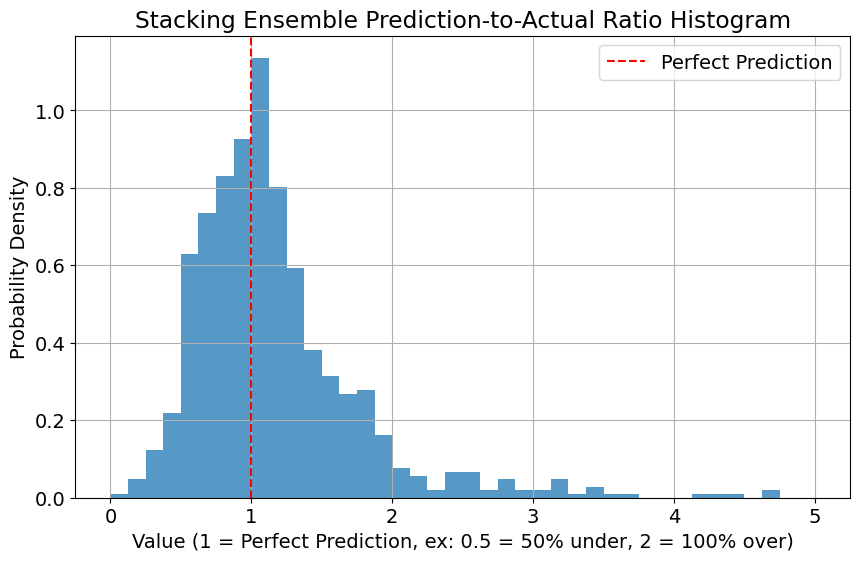

In [58]:
# distribution of accuracy of stacking ensemble
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10, 6))
plt.hist(ensemble_predictions / y_test, bins=40, range=(0, 5), density=True, alpha=0.75)
plt.axvline(1, color='red', linestyle='--', label='Perfect Prediction')
plt.title("Stacking Ensemble Prediction-to-Actual Ratio Histogram")
plt.xlabel("Value (1 = Perfect Prediction, ex: 0.5 = 50% under, 2 = 100% over)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()

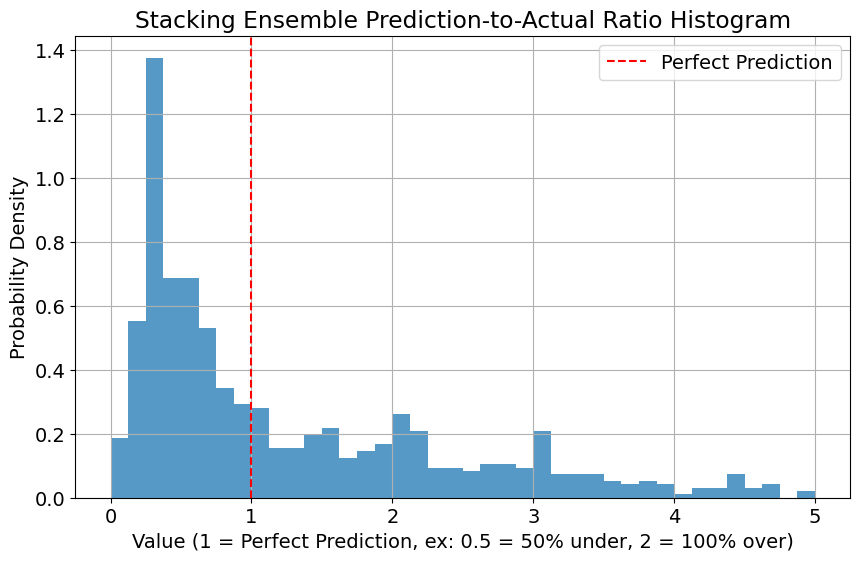

In [59]:
# distribution of accuracy of stacking ensemble
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10, 6))
plt.hist(stacked_predictions / y_test, bins=40, range=(0, 5), density=True, alpha=0.75)
plt.axvline(1, color='red', linestyle='--', label='Perfect Prediction')
plt.title("Stacking Ensemble Prediction-to-Actual Ratio Histogram")
plt.xlabel("Value (1 = Perfect Prediction, ex: 0.5 = 50% under, 2 = 100% over)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()